In [1]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import Parameter
import matplotlib.pyplot as plt
from svetlanna import wavefront as w
from svetlanna.units import ureg

# Использование нелинейного элемента

Нелинейный элемент позволяет управлять интенсивностью падающего волнового фронта с сохранением фазового распределения. Для того, чтобы определить нелинейный элемент, необходимо передать в конструктор функцию```response_function```, задающую преобразование. амплитуды падающего волнового фронта. В качестве примера рассмотрим функцию сигмоиды и падающий пучок Гаусса. 

In [3]:
def response_sigmoid(x):
    return 10 / (1 + torch.exp(-x)) - 5

## Создание расчетной сетки с использованием класса`SimulationParameters`

In [4]:
wavelength = 1064 * ureg.nm # длина волны, нм
lx = 15 * ureg.mm # размер экрана по оси x, мм
ly = 8 * ureg.mm # размер экрана по оси y, мм

Nx = 1200 # количество узлов по оси x
Ny = 1100 # количество узлов по оси y

x_length = torch.linspace(-lx / 2, lx / 2, Nx)
y_length = torch.linspace(-ly / 2, ly / 2, Ny)

params = SimulationParameters(
    axes={
            'W': x_length,
            'H': y_length,
            'wavelength': wavelength
        }
)
xv, yv = params.meshgrid(x_axis='W', y_axis='H')


## Создание пучка Гаусса с использованием`svetlanna.wavefront.gaussian_beam`

Создадим пучок Гаусса, который будет падать на нелинейный элемент.

In [5]:
incident_wavefront = w.Wavefront.gaussian_beam(
    simulation_parameters=params,
    waist_radius=2. * ureg.mm,
    distance=10 * ureg.cm
)
intensity_input = incident_wavefront.intensity

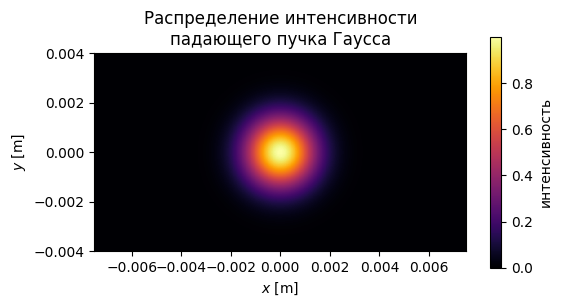

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))
im1 = ax.pcolormesh(xv, yv, intensity_input, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Распределение интенсивности\nпадающего пучка Гаусса')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='интенсивность')

## Создание нелинейного элемента с использованием `svetlanna.elements.NonlinearElement`

В этой секции создадим нелинейный элемент с определенной выше функцией response_function:

In [7]:
nl_element = elements.NonlinearElement(
    simulation_parameters=params,
    response_function=response_sigmoid
)

transmitted_wavefront = nl_element.forward(incident_wavefront=incident_wavefront)
intensity_output = transmitted_wavefront.intensity

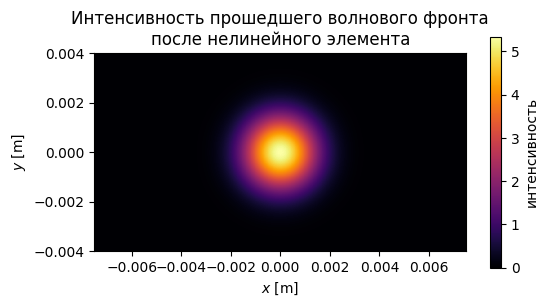

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))
im1 = ax.pcolormesh(xv, yv, intensity_output, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Интенсивность прошедшего волнового фронта\nпосле нелинейного элемента')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='интенсивность')

Text(0, 0.5, '$интенсивность$')

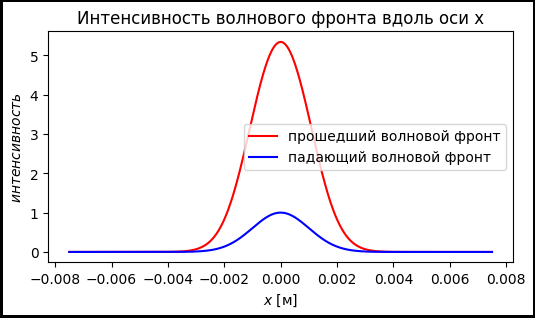

In [9]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)

ax.set_title("Интенсивность волнового фронта вдоль оси x")
ax.plot(xv[int(Ny/2)], intensity_output[int(Ny/2)], color='red', label="прошедший волновой фронт")
ax.plot(xv[int(Ny/2)], intensity_input[int(Ny/2)], color='blue', label="падающий волновой фронт")
ax.legend()
ax.set_xlabel('$x$ [м]')
ax.set_ylabel('$интенсивность$')


## Обучение параметров функции нелинейного элемента response function
Если необходимо обучить параметры функции нелинейного элемента, то существует возможность реализовать это, передав в конструктор класса `__init__` нелинейного элемента объект словарь `Dict`, содержащий параметры для обучения, обернутые в класс `Parameter`. Такие обернутые параметры могут быть обучены

In [10]:
def arbitrary_function(x, parameter1, parameter2, parameter3):
    return parameter1 / (1 + torch.exp(-x * parameter2)) + parameter3 - 150

nl_to_train = elements.NonlinearElement(
    simulation_parameters=params,
    response_function=arbitrary_function,
    response_parameters={
        "parameter1": Parameter(100.),
        "parameter2": Parameter(40.),
        "parameter3": 100.
    }
)

output_field_to_train = nl_to_train.forward(incident_wavefront=incident_wavefront)
intensity_output_to_train = output_field_to_train.intensity

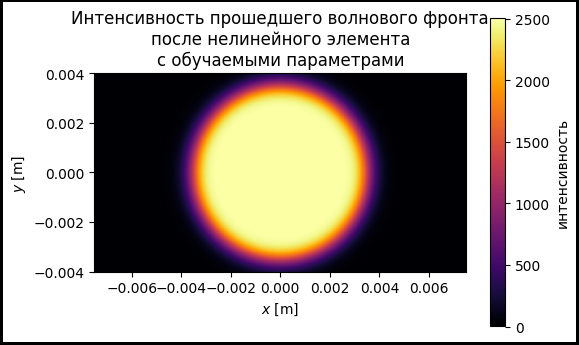

In [11]:
fig, ax = plt.subplots(figsize=(6, 4), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(xv, yv, intensity_output_to_train.detach(), cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Интенсивность прошедшего волнового фронта\nпосле нелинейного элемента\nс обучаемыми параметрами')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='интенсивность')

Text(0, 0.5, '$интенсивность$')

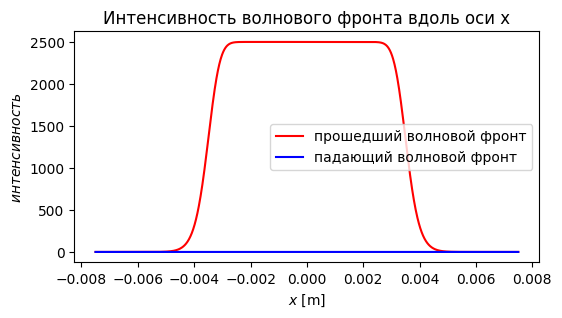

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.set_title("Интенсивность волнового фронта вдоль оси x")
ax.plot(xv[int(Ny/2)], intensity_output_to_train[int(Ny/2)].detach(), color='red', label="прошедший волновой фронт")
ax.plot(xv[int(Ny/2)], intensity_input[int(Ny/2)], color='blue', label="падающий волновой фронт")
ax.legend()
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$интенсивность$')